## 1. Import Libraries and Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import operator
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier

from sklearn.multioutput import MultiOutputClassifier

In [2]:
dataset_scaled = pd.read_csv('DATASET.csv')

In [3]:
pleasant_weather = pd.read_csv('Dataset-Answers-Weather_Prediction_Pleasant_Weather.csv')

In [4]:
print(dataset_scaled.dtypes.to_string())

DATE                             int64
MONTH                            int64
BASEL_cloud_cover              float64
BASEL_wind_speed               float64
BASEL_humidity                 float64
BASEL_pressure                 float64
BASEL_global_radiation         float64
BASEL_precipitation            float64
BASEL_snow_depth               float64
BASEL_sunshine                 float64
BASEL_temp_mean                float64
BASEL_temp_min                 float64
BASEL_temp_max                 float64
BELGRADE_cloud_cover           float64
BELGRADE_humidity              float64
BELGRADE_pressure              float64
BELGRADE_global_radiation      float64
BELGRADE_precipitation         float64
BELGRADE_sunshine              float64
BELGRADE_temp_mean             float64
BELGRADE_temp_min              float64
BELGRADE_temp_max              float64
BUDAPEST_cloud_cover           float64
BUDAPEST_humidity              float64
BUDAPEST_pressure              float64
BUDAPEST_global_radiation

In [5]:
print(pleasant_weather.dtypes.to_string())

DATE                           int64
BASEL_pleasant_weather         int64
BELGRADE_pleasant_weather      int64
BUDAPEST_pleasant_weather      int64
DEBILT_pleasant_weather        int64
DUSSELDORF_pleasant_weather    int64
HEATHROW_pleasant_weather      int64
KASSEL_pleasant_weather        int64
LJUBLJANA_pleasant_weather     int64
MAASTRICHT_pleasant_weather    int64
MADRID_pleasant_weather        int64
MUNCHENB_pleasant_weather      int64
OSLO_pleasant_weather          int64
SONNBLICK_pleasant_weather     int64
STOCKHOLM_pleasant_weather     int64
VALENTIA_pleasant_weather      int64


###  Curate temperature variables & exclude Gdasnk, Roma, Tour

In [6]:
### List comprehension to filter columns
columns_to_keep = [
    col for col in dataset_scaled.columns
    if 'temp_' in col
    and not any(city in col for city in ['ROMA', 'TOURS', 'GDANSK'])
]

# Create the new DataFrame
df_temp = dataset_scaled[columns_to_keep]


In [7]:
df_temp.shape

(22950, 45)

In [8]:
pleasant_weather.shape

(22950, 16)

## 2. Prepare Training Dataset

In [9]:
### Create an 'X' matrix; drop unneeded columns
X = df_temp
y = pleasant_weather.drop(['DATE'], axis=1)

In [10]:
### Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [11]:
#viewing shape of training and test sets
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(17212, 45)
(5738, 45)
(17212, 15)
(5738, 15)


## 3. Decision Tree

#### Attempt #1

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Step 1: Create a baseline Decision Tree model
dt = DecisionTreeClassifier(random_state=42)

# Step 2: Fit the model
dt.fit(X_train, y_train)

# Step 3: Predict on training and testing sets
y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)

# Step 4: Accuracy scores
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print("Train Accuracy:", train_acc)
print("Test Accuracy:", test_acc)


Train Accuracy: 1.0
Test Accuracy: 0.4710700592540955


### Observations:
Accuracy metrics indicate overfitting-- the model memorized the training set, but the poor performance on the test data indicates that it hasn’t generalized; the model is parroting the training examples.

#### Attempt #2

In [14]:
dt2 = DecisionTreeClassifier(max_depth=5, min_samples_leaf=10, random_state=42)
dt2.fit(X_train, y_train)

y_train_pred2 = dt2.predict(X_train)
y_test_pred2 = dt2.predict(X_test)

print("Train Accuracy:", accuracy_score(y_train, y_train_pred2))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred2))


Train Accuracy: 0.47298396467580756
Test Accuracy: 0.4754269780411293


### Observations:

Train Accuracy dropped, signaling the tree now lacks the complexity to capture meaningful patterns, even on the data it has seen. But Testing did not improve, so we lost learning without gaining generalization.

### Attempt #3

In [15]:
dt3 = DecisionTreeClassifier(max_depth=10, min_samples_leaf=5, random_state=42)
dt3.fit(X_train, y_train)

y_train_pred3 = dt3.predict(X_train)
y_test_pred3 = dt3.predict(X_test)

print("Train Accuracy:", accuracy_score(y_train, y_train_pred3))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred3))


Train Accuracy: 0.5342784104113409
Test Accuracy: 0.4900662251655629


### Observations:
- Train Accuracy ~53%: No longer memorizing — the model is trying to learn actual patterns.
- Test Accuracy ~49%: Better generalization than before, and slowly approaching parity with train accuracy.
- Gap is Narrow: It suggests the model is learning consistently, even if modestly.

The Decision Tree could benefit from further pruning, as the test accuracy remains low.



# Confusion Matrices

In [17]:
### Make predictions with dt3

y_pred_dt3 = dt3.predict(X_test)

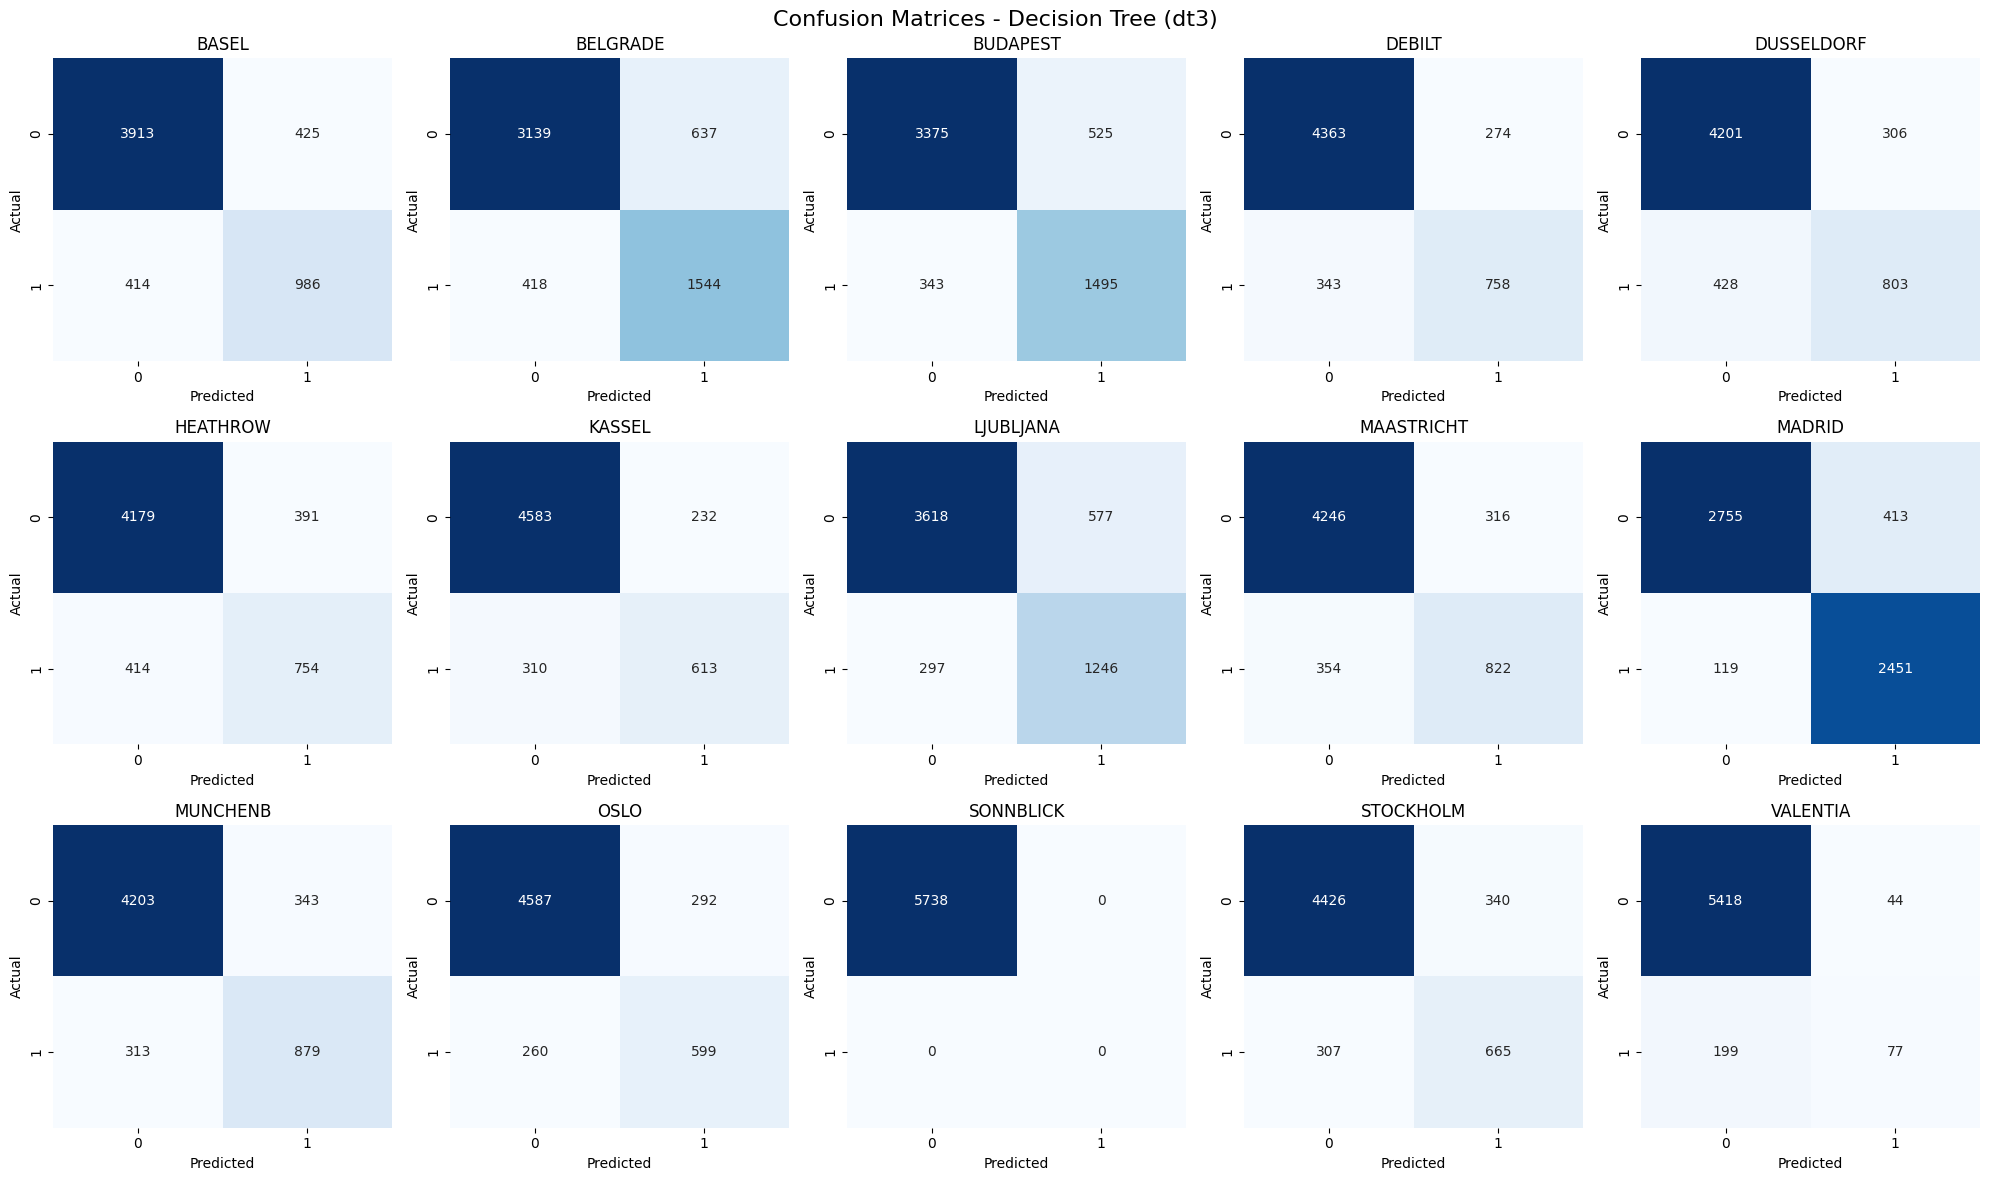

In [20]:
### Call the Plotting Function

station_names = [
    'BASEL', 'BELGRADE', 'BUDAPEST', 'DEBILT', 'DUSSELDORF', 'HEATHROW',
    'KASSEL', 'LJUBLJANA', 'MAASTRICHT', 'MADRID', 'MUNCHENB', 'OSLO',
    'SONNBLICK', 'STOCKHOLM', 'VALENTIA'
]

def plot_multi_confusion_matrix(y_true, y_pred_dt3, model_name, station_names=None):
    mcm = multilabel_confusion_matrix(y_true, y_pred_dt3)
    num_stations = len(mcm)

    fig, axes = plt.subplots(3, 5, figsize=(20, 12))
    fig.suptitle(f"Confusion Matrices - {model_name}", fontsize=16)

    for i, ax in enumerate(axes.flat):
        if i >= num_stations:
            ax.axis('off')
            continue
        cm = mcm[i]
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
        # Use station_names list for titles, else default to Station i
        title = station_names[i] if station_names else f"Station {i}"
        ax.set_title(title, fontsize=12)
    plt.tight_layout()
    plt.show()

plot_multi_confusion_matrix(y_test, y_pred_dt3, model_name="Decision Tree (dt3)", station_names=station_names)


## 🔎 General Observations from the Confusion Matrices
**1. High True Negatives Across the Board**
Almost every station has a very high number of true negatives (top-left cell).

**2. Lower True Positives (bottom-right), Many False Negatives**
Stations like BASEL, BELGRADE, HEATHROW, KASSEL, VALENTIA show Low True Positive (TP) counts and High False Negatives (FN) — the model is missing a lot of pleasant days.

**3. SONNBLICK = Red Flag**
It’s predicting nothing but 0 — zero predictions for class 1. (Signs overfitting and/or class imbalance-- the model just learned to default to the majority class.)

**4. Some Stations Are Relatively Balanced**
MADRID, BUDAPEST, LJUBLJANA show more even performance across both classes. These are likely benefiting from cleaner, more learnable signal.

# Decision Tree Visualization

[Text(0.41817310110663986, 0.9545454545454546, 'DUSSELDORF_temp_max <= 0.403\ngini = 0.316\nsamples = 100.0%\nvalue = [[0.752, 0.248]\n[0.65, 0.35]\n[0.675, 0.325]\n[0.805, 0.195]\n[0.785, 0.215]\n[0.78, 0.22]\n[0.834, 0.166]\n[0.719, 0.281]\n[0.791, 0.209]\n[0.554, 0.446]\n[0.792, 0.208]\n[0.842, 0.158]\n[1.0, 0.0]\n[0.83, 0.17]\n[0.948, 0.052]]'),
 Text(0.14858683350100604, 0.8636363636363636, 'MADRID_temp_max <= -0.216\ngini = 0.099\nsamples = 62.6%\nvalue = [[0.938, 0.062]\n[0.839, 0.161]\n[0.882, 0.118]\n[0.992, 0.008]\n[1.0, 0.0]\n[0.941, 0.059]\n[0.992, 0.008]\n[0.911, 0.089]\n[0.994, 0.006]\n[0.744, 0.256]\n[0.962, 0.038]\n[0.975, 0.025]\n[1.0, 0.0]\n[0.977, 0.023]\n[0.985, 0.015]]'),
 Text(0.283379967303823, 0.9090909090909092, 'True  '),
 Text(0.05306841046277666, 0.7727272727272727, 'BELGRADE_temp_max <= 0.053\ngini = 0.028\nsamples = 43.9%\nvalue = [[0.984, 0.016]\n[0.909, 0.091]\n[0.953, 0.047]\n[0.998, 0.002]\n[1.0, 0.0]\n[0.995, 0.005]\n[0.997, 0.003]\n[0.971, 0.029]\n[0

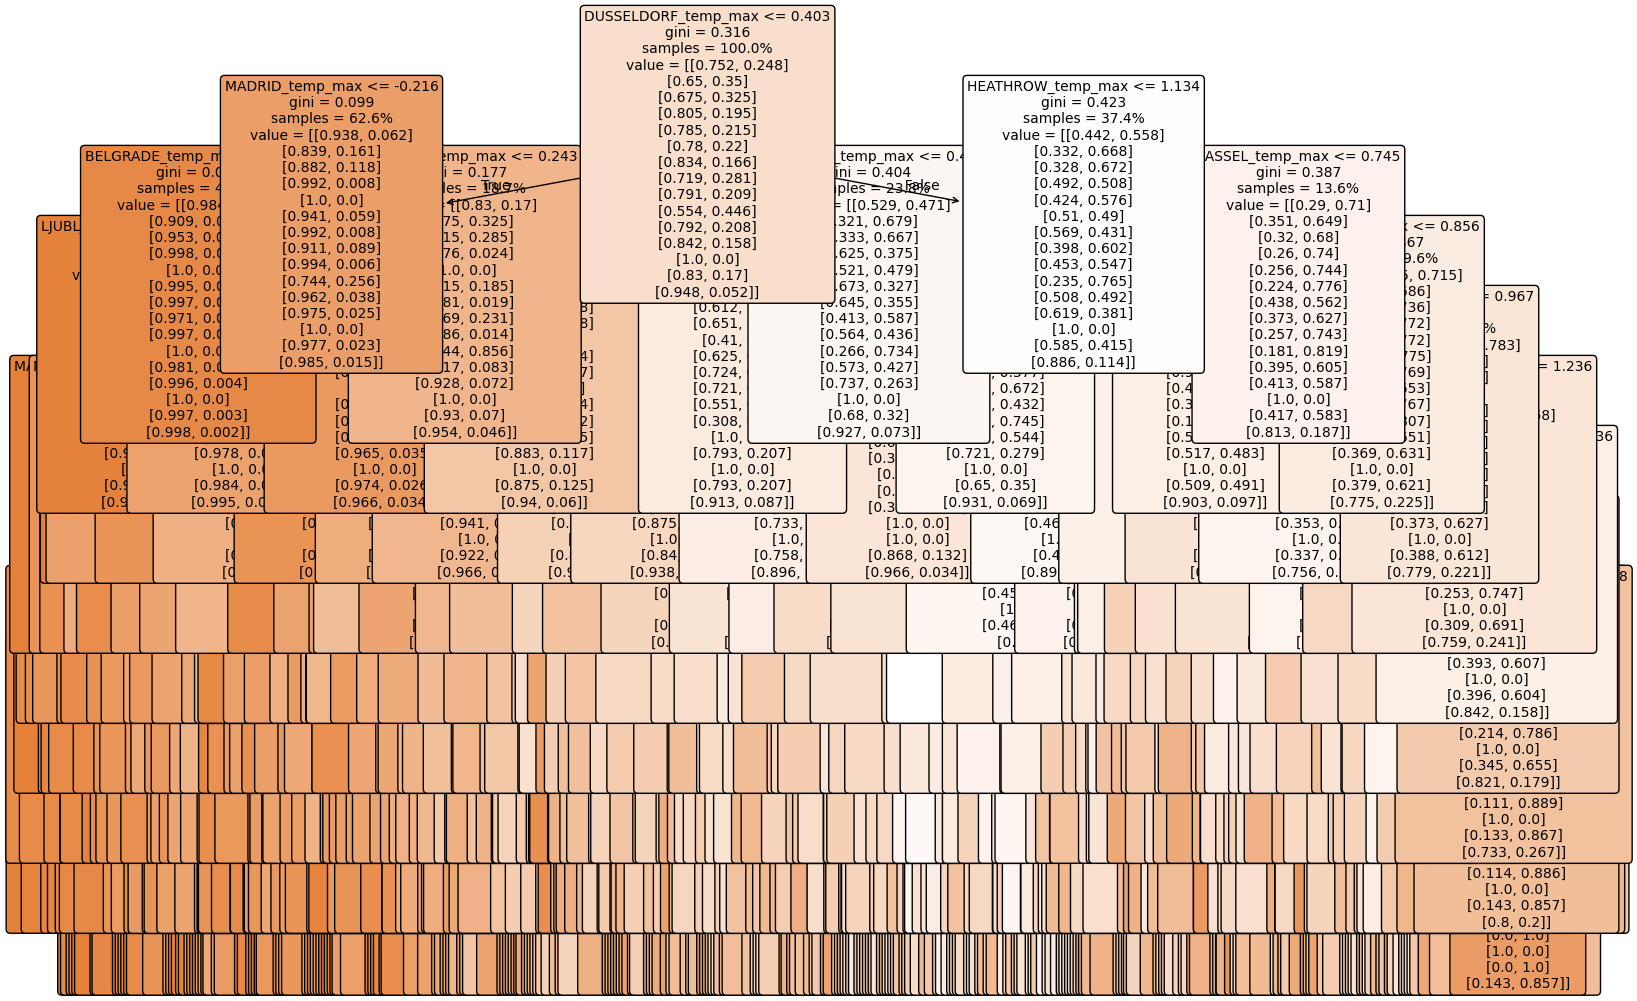

In [16]:
from matplotlib.pyplot import figure
from sklearn import tree

figure(figsize=(18, 10))  # Adjust size as needed

tree.plot_tree(
    dt3,
    filled=True,
    feature_names=X.columns,
    class_names=[str(i) for i in range(y.shape[1])],  # or proper station names if binary multilabel
    impurity=True,
    proportion=True,
    rounded=True,
    fontsize=10
)
